In [1]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials
using Random
using JLD2

Using 4 species instead of 2 and an explicit time delay allows for using faster solver and does not require nearly as much memory to run.

Added diffusion for pak that is a 2X faster than rhoT to prevent chasing, where rhoT creates waves, and because makes sense for a more peripheral protein.

Oscillation and equalization observed.

With same concentration of total Rho as simpilist with scaling model, this produces more polarity patches (as parameterized).
Reducing concentration reduces patch number.

In [2]:
function setup(r)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,4)
    Random.seed!(1)
    r0[:,:,1] .= 10 .*(rand.())   # Cdc42-GTPm
    r0[:,:,2] .= 0.5 - mean(r0[:,:,1])*n   # Cdc42-GDPm
    r0[:,:,3] .= 1
    r0[:,:,4] .= 10 .*(rand.())
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    Dpak = zeros(N,N)
    Dgef = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, Dpak, Dgef, R)
    # Actual parameters
    a = 1
    b = .1
    c = 1
    d = .05 #.02
    e = .07
    f = .2 #.2
    g = .1 # .1
    Dm = 0.01
    Dc = 10
    Dm2 = 0.1
    n = n

    p = (a, b, c, d, e, f, g, Dm, Dc, Dm2, n, Ax, Ay, dummy)
    return p, r0
end

setup (generic function with 1 method)

In [3]:
function simple!(dr,r,p,t)
    a, b, c, d, e, f, g, Dm, Dc, Dm2, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, Dpak, Dgef, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    pak = @view r[:,:,3]
    gef = @view r[:,:,4]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,pak)
    mul!(tAx,pak,Ax)
    @. Dpak = Dm2*(Ayt + tAx)
    mul!(Ayt,Ay,gef)
    mul!(tAx,gef,Ax)
    @. Dgef = Dm*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*gef^2*rhoD) - b*rhoT
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
    @. dr[:,:,3] = d*rhoT - e*pak + Dpak
    @. dr[:,:,4] = 0.001 + f*rhoT - g*pak*gef + Dgef # Small constant recruitment avoids an absolute zero steady-state
end


simple! (generic function with 1 method)

In [4]:
function run(radius)
    p, r0 = setup(radius)
    min_prob = ODEProblem(simple!,r0,(0.0,1800),p)
    sol_simp = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=1)
    return sol_simp
end

run (generic function with 1 method)

In [180]:
sol5 = run(5)

retcode: Success
Interpolation: 1st order linear
t: 1801-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 1792.0
 1793.0
 1794.0
 1795.0
 1796.0
 1797.0
 1798.0
 1799.0
 1800.0
u: 1801-element Vector{Array{Float64, 3}}:
 [0.7336635446929285 1.670529092877866 … 4.498294423109524 4.346647867723758; 3.4924148955718612 7.197206925405183 … 8.084217249744095 9.244406861511123; … ; 8.338534481533054 3.6131523841038513 … 3.295155127929638 5.904229678435289; 9.817043479487307 3.618757071379193 … 3.1065190965909384 2.26016435978588;;; 0.4699682520866589 0.4699682520866589 … 0.4699682520866589 0.4699682520866589; 0.4699682520866589 0.4699682520866589 … 0.4699682520866589 0.4699682520866589; … ; 0.4699682520866589 0.4699682520866589 … 0.4699682520866589 0.4699682520866589; 0.4699682520866589 0.4699682520866589 … 0.4699682520866589 0.4699682520866589;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;; 4.

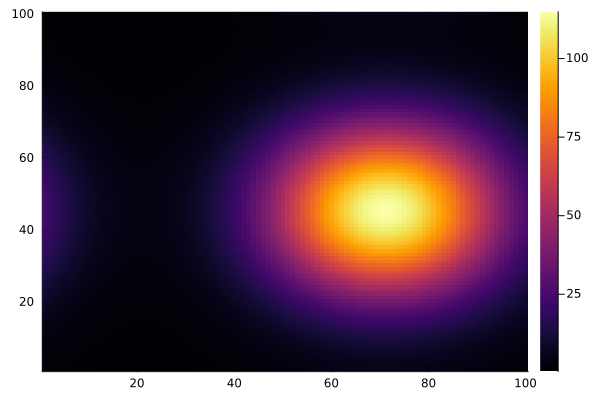

In [181]:
heatmap(sol[:,:,1,end])

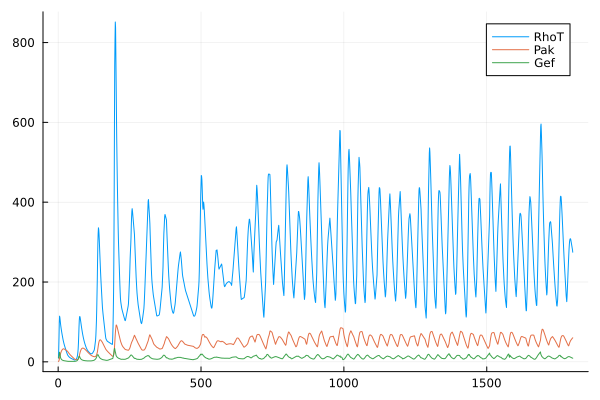

In [182]:
r=5
SA = 4*pi*r^2
V = (4/3)*pi*r^3
mem_thickness = 0.01
n = (mem_thickness * SA) / V

T = dropdims(maximum(sol5[:,:,1,:], dims=(1,2)), dims = (1,2))
D = dropdims(maximum(sol5[:,:,2,:], dims=(1,2)), dims = (1,2))./n
P = dropdims(maximum(sol5[:,:,3,:], dims=(1,2)), dims = (1,2))
G = dropdims(maximum(sol5[:,:,4,:], dims=(1,2)), dims = (1,2))
plot(T, label="RhoT")
plot!(P, label="Pak")
plot!(G, label="Gef")
#plot!(D, label="RhoD")

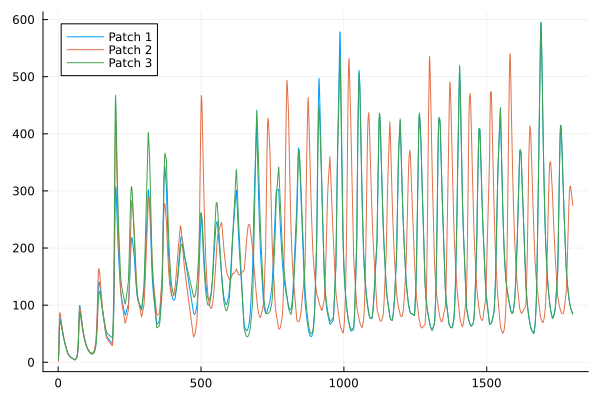

In [183]:
r=5
SA = 4*pi*r^2
V = (4/3)*pi*r^3
mem_thickness = 0.01
n = (mem_thickness * SA) / V
s = sol5[:,:,1,:]
coords = findlocalmaxima(s[:,:,end],edges=false)
T = s[coords[1],:]
T2 = s[coords[2],:]
T3 = s[coords[3],:]

plot(T, label="Patch 1")
plot!(T2, label="Patch 2")
plot!(T3, label="Patch 3")

In [197]:
anim = @animate for i in 1:360
    Plots.heatmap(sol5[:,:,1,i*5],clim=(0,maximum(sol[:,:,1,:])), title="t = $(i*5) seconds")
end
gif(anim, fps=10)
gif(anim, "tmp_negFB_r5.gif", fps=60)

┌ Info: Saved animation to /tmp/jl_7AZCdEdota.gif
└ @ Plots /home/dinosaur/.julia/packages/Plots/HyyIK/src/animation.jl:156


In [185]:
sol = run(2.5)

retcode: Success
Interpolation: 1st order linear
t: 1801-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 1792.0
 1793.0
 1794.0
 1795.0
 1796.0
 1797.0
 1798.0
 1799.0
 1800.0
u: 1801-element Vector{Array{Float64, 3}}:
 [0.7336635446929285 1.670529092877866 … 4.498294423109524 4.346647867723758; 3.4924148955718612 7.197206925405183 … 8.084217249744095 9.244406861511123; … ; 8.338534481533054 3.6131523841038513 … 3.295155127929638 5.904229678435289; 9.817043479487307 3.618757071379193 … 3.1065190965909384 2.26016435978588;;; 0.43993650417331776 0.43993650417331776 … 0.43993650417331776 0.43993650417331776; 0.43993650417331776 0.43993650417331776 … 0.43993650417331776 0.43993650417331776; … ; 0.43993650417331776 0.43993650417331776 … 0.43993650417331776 0.43993650417331776; 0.43993650417331776 0.43993650417331776 … 0.43993650417331776 0.43993650417331776;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0

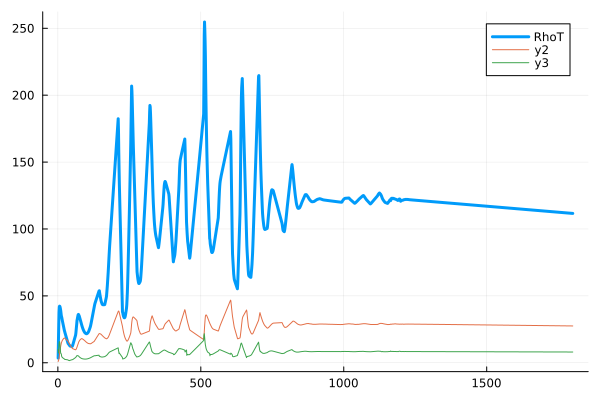

In [186]:
r=5
SA = 4*pi*r^2
V = (4/3)*pi*r^3
mem_thickness = 0.01
n = (mem_thickness * SA) / V
s = sol[:,:,1,:]
coords = findlocalmaxima(s[:,:,end],edges=false)
T = s[coords[1],:]
#T2 = s[coords[2],:]

plot(T, label="RhoT", linewidth=3)
P = dropdims(maximum(sol[:,:,3,:], dims=(1,2)), dims = (1,2))
plot!(P)
P = dropdims(maximum(sol[:,:,4,:], dims=(1,2)), dims = (1,2))
plot!(P)
#plot!(T2, label="RhoT", linewidth=3)
#plot!(T3, label="RhoT")
savefig("tmp_negFB_patchMaxes.png")

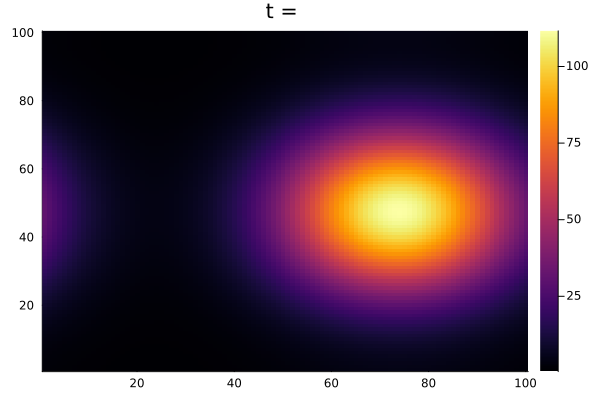

In [194]:
Plots.heatmap(sol[:,:,1,end])

In [ ]:
anim = @animate for i in 1:360
    Plots.heatmap(sol[:,:,1,i*5],clim=(0,maximum(sol[:,:,1,:])), title="t = $(i*5) seconds")
end
gif(anim, fps=10)
gif(anim, "tmp_negFB_r2.gif", fps=60)

In [6]:
function run(radius)
    p, r0 = setup(radius)
    min_prob = ODEProblem(simple!,r0,(0.0,1),p)
    sol_simp = solve(min_prob,TRBDF2(),saveat=1)
    return sol_simp
end

run (generic function with 1 method)

In [7]:
sol = run(2.5)

In [305]:
# ODEs
function rhosim(du,u,p,t)
    rhoT, rhoD, pak = u
    a, b, c, d, e = p
    r = (a*rhoT^2*rhoD) - b*rhoT - c*rhoT*pak^2
    du[1] = r
    du[2] = -r
    du[3] = d*rhoT - e*pak
end

rhosim (generic function with 1 method)

In [318]:
a = 2
b = 0.25
c = 1
d = 0.001
e = 0.001
p = [a,b,c,d,e]
u0 = [1,100,0]

3-element Vector{Int64}:
   1
 100
   0

In [164]:
function run_ode(p,u0)
    min_prob = ODEProblem(rhosim,u0,(0.0,600),p)
    sol_simp = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=1)
    return sol_simp
end

run_ode (generic function with 1 method)

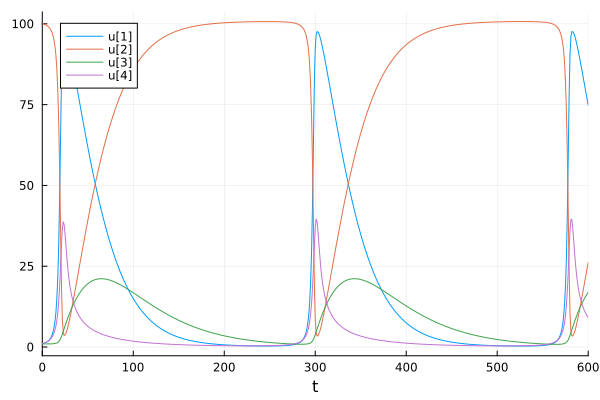

In [868]:
odesol = run_ode(p, u0)
plot(odesol)

In [165]:
# ODEs
function rhosim(du,u,p,t)
    rhoT, rhoD, pak, gef = u
    a, b, c, d, e, f = p
    r = (a*gef^2*rhoD) - b*rhoT
    du[1] = r 
    du[2] = -r 
    du[3] = d*rhoT - e*pak  #pak
    du[4] = f*rhoT - g*pak*gef #gef
end

a = .001
b = .1
c = 1
d = .01
e = .035
f = .2
g = .1
p = [a,b,c,d,e,f,g]
u0 = [1,100,1,1]

4-element Vector{Int64}:
   1
 100
   1
   1

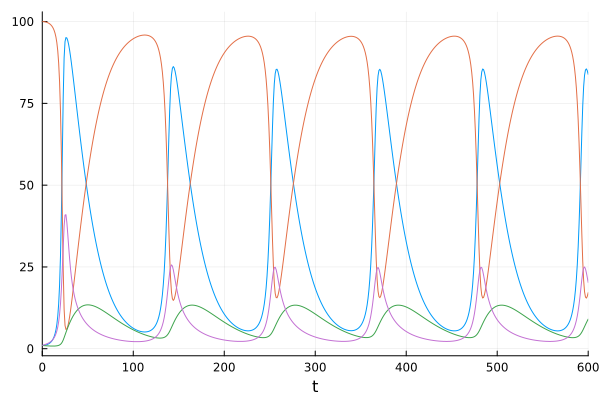

In [166]:
odesol = run_ode(p, u0)
plot(odesol, legend=false)

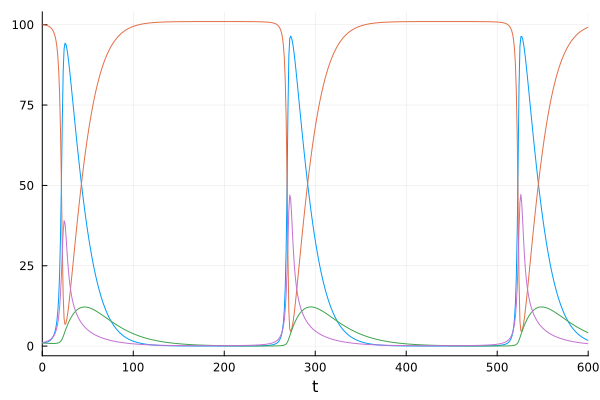

In [334]:
# ODEs
function rhosim(du,u,p,t)
    rhoT, rhoD, pak, gef = u
    a, b, c, d, e, f = p
    r = (a*gef^2*rhoD) - b*rhoT
    du[1] = r 
    du[2] = -r 
    du[3] = d*rhoT - e*pak  #pak
    du[4] = f*rhoT - g*pak*gef #gef
end

a = .001
b = .1
c = 1
d = .01
e = .035
f = .25
g = .15
p = [a,b,c,d,e,f,g]
u0 = [1,100,1,1]

odesol = run_ode(p, u0)
plot(odesol, legend=false)